In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [61]:
dataset_to_task = dict(
    dansk='ner',
    angry_tweets='sent',
    scala_da='la',
    scandiqa_da='qa',
    norne_nb='ner',
    norne_nn='ner',
    norec='sent',
    scala_nb='la',
    scala_nn='la',
    norquad='qa',
    suc3='ner',
    swerec='sent',
    scala_sv='la',
    scandiqa_sv='qa',
    conll_en='ner',
    sst5='sent',
    scala_en='la',
    squad='qa',
)

In [62]:
def load_results_dataframe(language: str) -> pd.DataFrame:
    df = pd.read_csv(f'https://scandeval.com/{language}-nlu.csv')

    df.drop(
        columns=[
            "num_model_parameters", 
            "vocabulary_size", 
            "max_sequence_length", 
            "speed",
        ] + [col for col in df.columns if "rank" in col], 
        inplace=True,
    )
    
    datasets = ['model_id']
    for task in ['ner', 'sent', 'la', 'qa']:
        datasets.extend([
            dataset
            for dataset in df.columns
            if dataset_to_task.get(dataset) == task
        ])
    df = df[datasets]
    
    df['generative'] = df.model_id.map(lambda x: "few-shot" in x)
    df.set_index('model_id', inplace=True)
    
    return df

In [75]:
df = load_results_dataframe(language="mainland-scandinavian")
df.head()

,dansk,norne_nb,norne_nn,suc3,angry_tweets,norec,swerec,scala_da,scala_nb,scala_nn,scala_sv,scandiqa_da,norquad,scandiqa_sv,generative
model_id,,,,,,,,,,,,,,,
"gpt-4-0613 (few-shot, val)",64.94,81.16,75.75,76.86,59.97,72.72,79.19,71.56,77.30,57.18,80.93,49.82,49.93,56.50,True
AI-Sweden-Models/roberta-large-1160k,74.16,92.01,87.17,82.65,51.20,60.11,77.25,73.87,72.85,65.56,77.90,49.34,60.38,49.64,False
ltg/norbert3-large,73.62,93.12,89.39,79.01,48.29,64.62,75.32,71.55,77.97,76.30,69.11,48.59,66.03,48.88,False
AI-Sweden-Models/roberta-large-1350k,75.22,92.49,87.22,82.97,49.94,58.77,77.37,72.59,76.30,64.11,73.81,48.97,60.69,49.50,False
danish-foundation-models/encoder-large-v1,74.60,88.66,84.59,74.18,51.42,55.59,75.11,76.11,71.43,53.30,64.11,47.42,57.38,46.79,False


<Axes: >

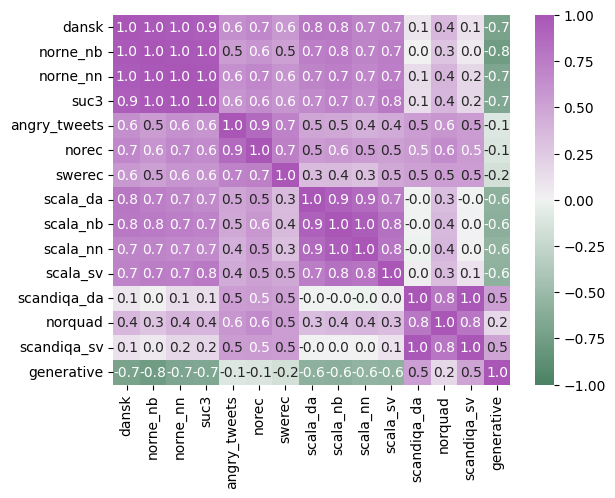

In [76]:
sns.heatmap(
    df.corr(), 
    annot=True, 
    fmt=".1f", 
    vmin=-1, 
    vmax=1, 
    cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
)

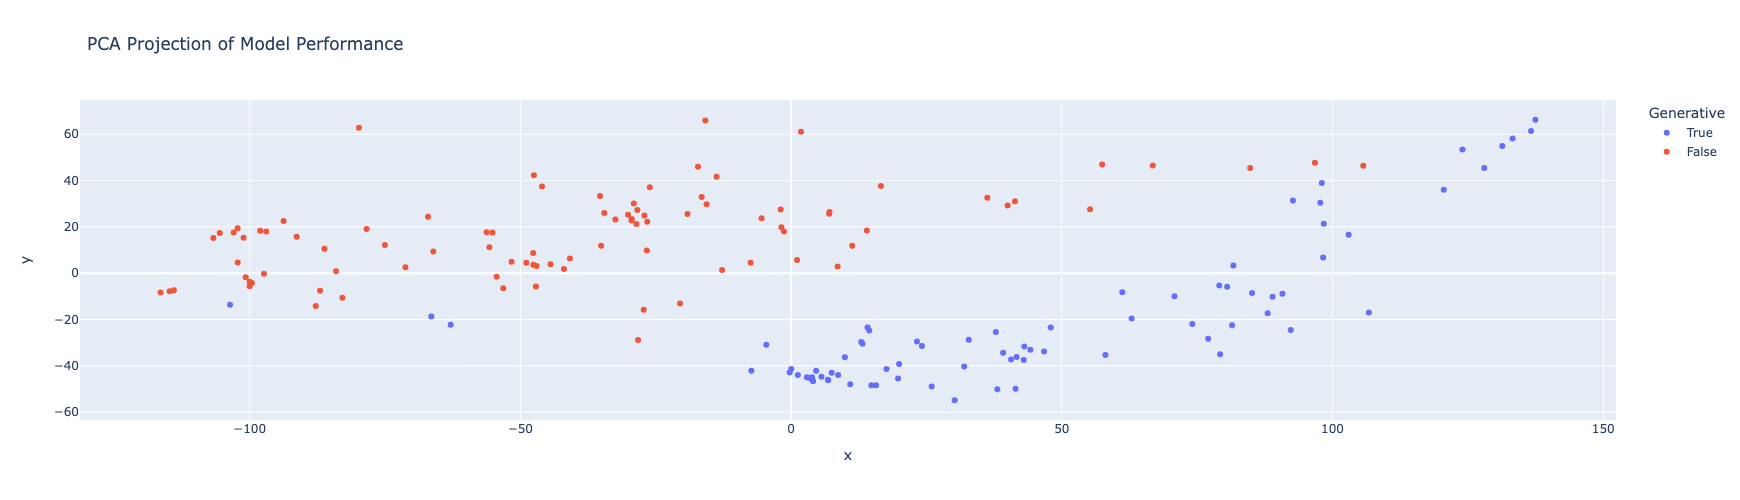

In [77]:
pca = PCA(n_components=2)
pca_projection = pca.fit_transform(df.drop(columns="generative"))
px.scatter(
    x=pca_projection[:, 0], 
    y=pca_projection[:, 1], 
    color=df.generative,
    hover_name=df.index.tolist(),
    width=650,
    height=500,
    title="PCA Projection of Model Performance",
    labels=dict(color="Generative"),
)

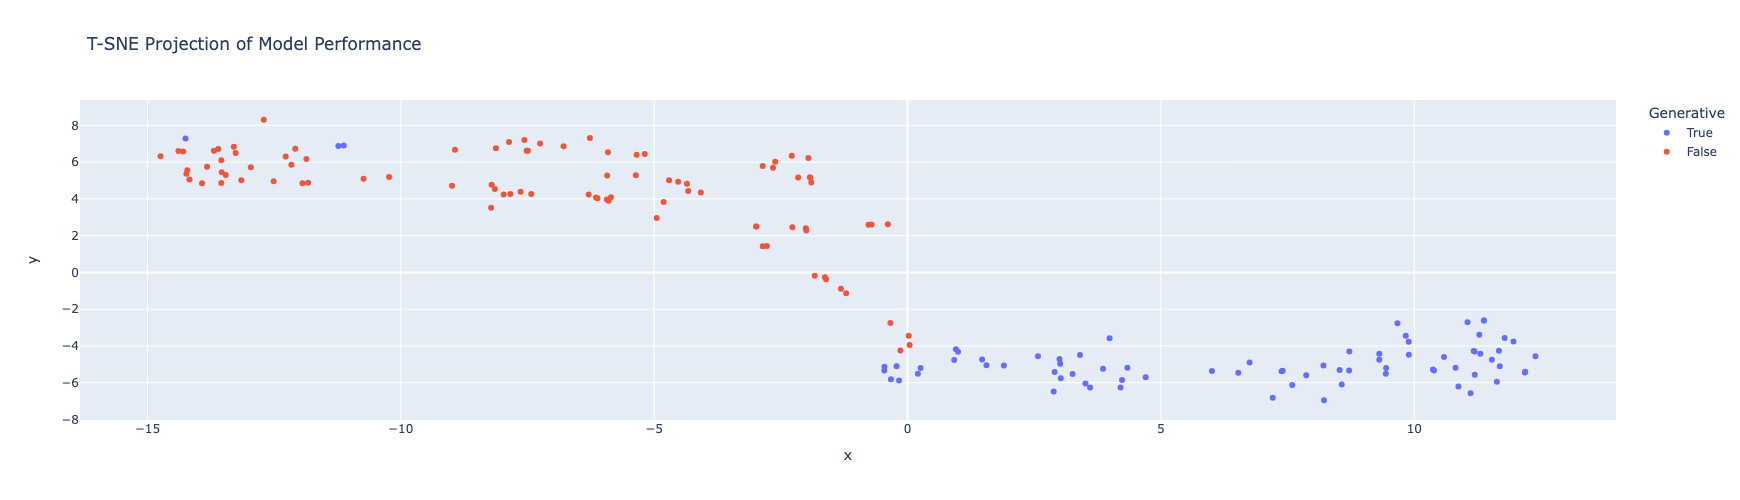

In [78]:
tsne = TSNE(n_components=2)
tsne_projection = tsne.fit_transform(df.drop(columns="generative"))
px.scatter(
    x=tsne_projection[:, 0], 
    y=tsne_projection[:, 1], 
    color=df.generative,
    hover_name=df.index.tolist(),
    width=650,
    height=500,
    title="T-SNE Projection of Model Performance",
    labels=dict(color="Generative"),
)

Using 84 neighbours.


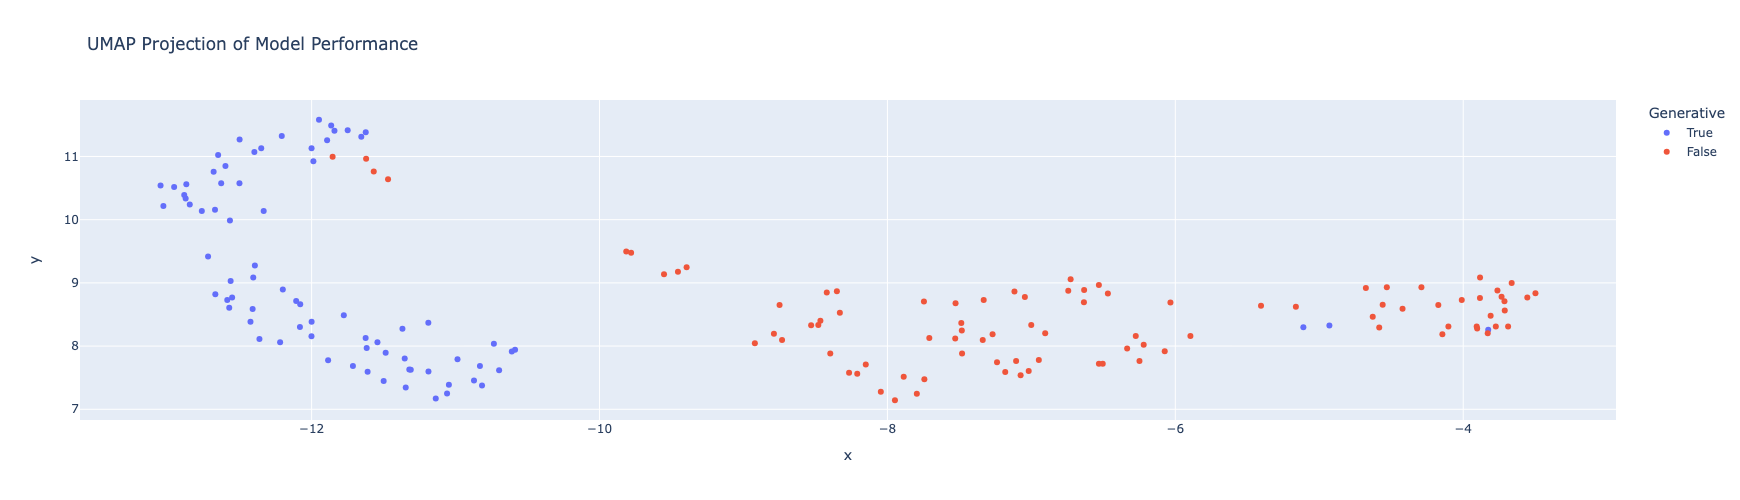

In [83]:
N_NEIGHBOURS = len(df) // 2

print(f"Using {N_NEIGHBOURS} neighbours.")
umap = UMAP(n_neighbors=N_NEIGHBOURS, n_components=2, random_state=4242, n_jobs=1)
umap_projection = umap.fit_transform(df.drop(columns="generative"))

px.scatter(
    x=umap_projection[:, 0], 
    y=umap_projection[:, 1], 
    color=df.generative,
    hover_name=df.index.tolist(),
    width=650,
    height=500,
    title=f"UMAP Projection of Model Performance",
    labels=dict(color="Generative"),
)